In [ ]:
import u6
import datetime
import os
import csv
# import time
import yaml
import numpy as np
import tkinter as tk
from tkinter import ttk
from tkinter import filedialog
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import pandas as pd
import time
import itertools  

############################### Create Data Save Directory ###############################

today = datetime.datetime.now()
path = f"x{today.strftime('%Y%m%d')}"

rootdir = f"C:\\Users\\zhewe\\Documents\\Data\\{path}"
if not os.path.exists(rootdir):
    os.mkdir(rootdir)

############################### Initiate LabJack Read Functions ###############################
d = u6.U6()
d.getCalibrationData()

def read_AIN(idx: int, resolutionindex: int = 13, gainindex: int = 0) -> float:
    """Reads the analog input channel

    Args:
        idx (int): anolog input channel index
        resolutionindex (int): resolution index for labjack
        gainindex (int): gain index for labjack
        
        idx: 14 is the internal temperature sensor and 15 is internal GND.
        ResolutionIndex: 0=default, 1-8 for high-speed ADC, 9-13 for high-res ADC on U6-Pro. Value in the response is the actual resolution setting used for the reading. 
        GainIndex: 0=x1, 1=x10, 2=x100, 3=x1000, 15=autorange. Value in the response is the actual gain setting used for the reading

    Returns:
        float: value read
    """

    return d.getAIN(idx, resolutionindex, gainindex)

################################ Read Device Name and Gain ###############################
with open('V3_Tracking_Doc.yaml', 'r') as file:
    data = yaml.safe_load(file)
    
def log_measurement(module_num):
    log_file_name = os.path.join(rootdir, f"{data[module_num]['name']}_measLog.csv")
    
    file_was_created = False
    if not os.path.exists(log_file_name):
        try:
            with open(log_file_name, 'x', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(['Time', 'Vsense (V)', 'Rsense (ohm)', 'Calc Current (A)'])
            file_was_created = True
        except FileExistsError:
            pass

    timestamp = datetime.datetime.now().timestamp()
    VGND = read_AIN(data[18]['port'])
    Vsense = read_AIN(data[module_num]['port'])
    Rsense = data[module_num]['Rsense']
    Gain = data[module_num]['Gain']
    CalcCurrent = (Vsense - VGND) / Rsense / Gain
    Note = data[module_num]['name']
    
    with open(log_file_name, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([timestamp, Vsense, Rsense, CalcCurrent])

    return CalcCurrent  # Always return the measured current



################################ UI Code ###############################

class MeasurementDisplayApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Measurement Display")
        self.root.geometry("800x600")

        # Data storage
        self.measurements = []

        # Treeview for displaying measurements
        self.tree = ttk.Treeview(root, columns=("Name", "Value", "Timestamp"), show="headings", height=10)
        self.tree.heading("Name", text="Module Name")
        self.tree.heading("Value", text="Leak Curr. Val.")
        self.tree.heading("Timestamp", text="Timestamp")
        self.tree.column("Name", width=200, anchor="center")
        self.tree.column("Value", width=150, anchor="center")
        self.tree.column("Timestamp", width=200, anchor="center")
        self.tree.pack(fill=tk.BOTH, expand=True)

        # Buttons
        self.button_frame = tk.Frame(root)
        self.button_frame.pack(pady=10)

        self.save_button = tk.Button(self.button_frame, text="Save to CSV", command=self.save_to_csv)
        self.save_button.pack(side=tk.LEFT, padx=5)

        self.plot_button = tk.Button(self.button_frame, text="Plot Measurements", command=self.plot_measurements)
        self.plot_button.pack(side=tk.LEFT, padx=5)

        # Matplotlib Figure for real-time plotting
        self.figure, self.ax = plt.subplots(figsize=(5, 3))
        self.ax.set_title("Real-Time Current Measurement Plot")
        self.ax.set_xlabel("Time (s)")
        self.ax.set_ylabel("Current (A)")
        self.ax.set_ylim(0, 0.1)  # Set the y-axis limit
        self.canvas = FigureCanvasTkAgg(self.figure, master=root)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

        # Start continuous measurement
        self.start_measurement()

    def add_measurement(self, name, value):
        """Add a new measurement to the display and update the plot."""
        timestamp = time.strftime("%Y-%m-%d %H:%M:%S")
        self.tree.insert("", "end", values=(name, value, timestamp))
        self.measurements.append({"Name": name, "Value": float(value), "Timestamp": timestamp})
        self.update_plot()

    def save_to_csv(self):
        """Save measurements to a CSV file."""
        if not self.measurements:
            tk.messagebox.showinfo("Info", "No measurements to save!")
            return

        file_path = filedialog.asksaveasfilename(defaultextension=".csv",
                                                 filetypes=[("CSV files", "*.csv")])
        if file_path:
            df = pd.DataFrame(self.measurements)
            df.to_csv(file_path, index=False)
            tk.messagebox.showinfo("Success", f"Measurements saved to {file_path}")

    def update_plot(self):
        """Update the real-time plot with the latest data."""
        self.ax.clear()
        self.ax.set_title("Real-Time Current Measurement Plot")
        self.ax.set_xlabel("Time (s)")
        self.ax.set_ylabel("Current (A)")
        self.ax.set_ylim(-0.1, 0.1)

        # Define a list of colors (Matplotlib provides many predefined ones)
        colors = itertools.cycle(["blue", "red", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"])

        # Plot each module separately with a unique color
        module_names = list(set(m["Name"] for m in self.measurements))  # Get unique module names
        color_map = {name: next(colors) for name in module_names}  # Assign colors

        for name in module_names:
            module_values = [m["Value"] for m in self.measurements if m["Name"] == name]
            if module_values:
                self.ax.plot(range(len(module_values)), module_values, marker="o", linestyle="-", color=color_map[name], label=name)

        self.ax.legend()  # Show legend to differentiate modules
        self.figure.tight_layout()
        self.canvas.draw()

    def plot_measurements(self):
        """Open a larger, interactive plot of the measurements."""
        if not self.measurements:
            tk.messagebox.showinfo("Info", "No measurements to plot!")
            return

        plt.figure(figsize=(8, 6))
        values = [m["Value"] for m in self.measurements]
        plt.plot(range(len(values)), values, marker="o", linestyle="-", color="green")
        plt.title("Measurement Plot")
        plt.xlabel("Measurement Index")
        plt.ylabel("Value")
        plt.grid(True)

        # Apply tight layout for the standalone plot
        plt.tight_layout()
        plt.show()

    def start_measurement(self):
        """Start continuous measurements every 15 seconds."""
        # Simulate a measurement
        for module_num in np.arange(0,11):
            simulated_name = data[module_num]['name']
            simulated_value = log_measurement(module_num = module_num)
            # print(simulated_value)
            self.add_measurement(simulated_name, simulated_value)
            time.sleep(0.5)
        # Schedule the next measurement in 15 seconds
        self.root.after(2000, self.start_measurement)


# Main execution
if __name__ == "__main__":
    # Create the main application window
    root = tk.Tk()
    app = MeasurementDisplayApp(root)

    # Start the GUI event loop
    root.mainloop()


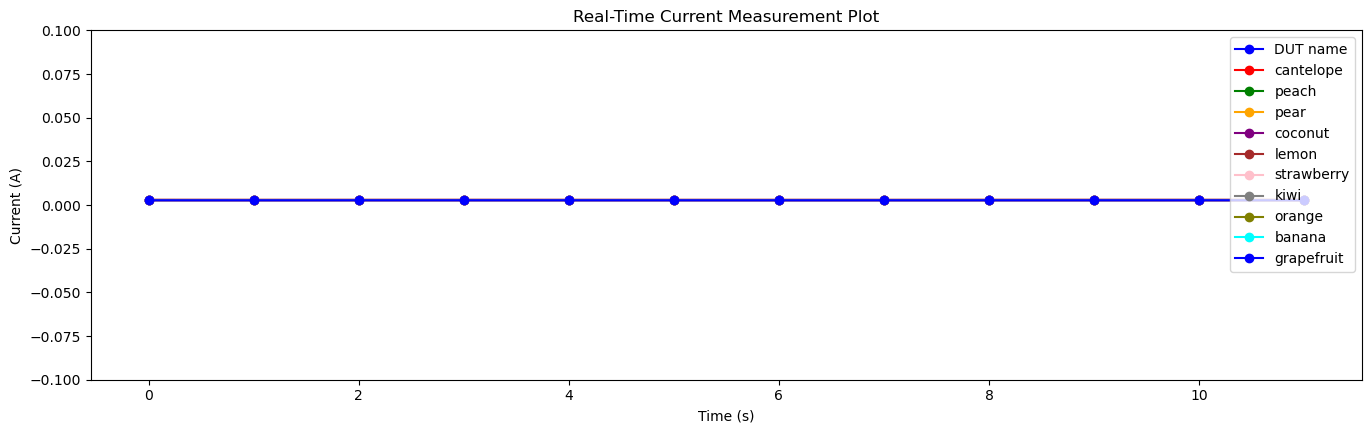